In [1]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Define Population parameter: 
P_DISEASE_GIVEN_EXPOSED = .4
P_DISEASE_GIVEN_UNEXPOSED = .3


In [3]:
def make_cohort(num_exposed, num_unexposed):
    patients =[]
    for i in range(num_exposed+num_unexposed):
        if i < num_exposed:
            exposed = True
            has_disease = np.random.choice([True, False], p=[P_DISEASE_GIVEN_EXPOSED,1-P_DISEASE_GIVEN_EXPOSED])

        else:
            exposed = False
            has_disease = np.random.choice([True, False], p=[P_DISEASE_GIVEN_UNEXPOSED,1-P_DISEASE_GIVEN_UNEXPOSED])
        patients.append({"patient_id": i, "exposed": exposed, "has_disease": has_disease})
    df = pd.DataFrame.from_records(patients)
    return df



In [4]:
def calc_OR(cohort):
    exposed_with_disease = len(cohort[(cohort['exposed'] == True) & (cohort['has_disease']==True)])
    exposed_without_disease = len(cohort[(cohort['exposed'] == True) & (cohort['has_disease']==False)])
    unexposed_with_disease = len(cohort[(cohort['exposed'] == False) & (cohort['has_disease']==True)])
    unexposed_without_disease = len(cohort[(cohort['exposed'] == False) & (cohort['has_disease']==False)])
    if unexposed_without_disease==0 or unexposed_with_disease ==0: #avoid division by zero and return large number
        return 1000000
    else:
        Odds_Ratio = (exposed_with_disease * unexposed_without_disease)/(exposed_without_disease * unexposed_with_disease) 
    return Odds_Ratio



In [5]:
def simulate_OR(num_sims:int =100, num_exposed: int =100, num_unexposed: int =100):
    ORs =[]
    for _ in range(num_sims):
        cohort = make_cohort(num_exposed=num_exposed, num_unexposed=num_unexposed)
        OR = calc_OR(cohort)
        ORs.append(OR)
    return ORs



In [6]:
def simulate_OR_different_ss(num_sims, exposed: List[int], unexposed: List[int]):
    experiments =[]
    for idx, _ in enumerate(exposed):
        num_exposed = exposed[idx]
        num_unexposed = unexposed[idx]
        ORs = simulate_OR(num_sims, num_exposed, num_unexposed)
        experiment = {"exposed_sample_size": num_exposed,
                       "unexposed_sample_size": num_unexposed,
                       "Distribution_Odds_Ratios": np.round(ORs,2) }
        experiments.append(experiment)
    exp_df = pd.DataFrame.from_records(experiments)
    return exp_df
    
    

,exposed_sample_size,unexposed_sample_size,Distribution_Odds_Ratios
0,450,450,"[1.52, 1.42, 1.39, 1.25, 1.34, 1.4, 2.11, 1.81..."
1,600,300,"[1.9, 1.31, 1.98, 1.74, 1.42, 1.36, 1.22, 1.44..."


In [9]:
def visualizeExperiment(df, same_axis: bool = False):
    # create figure and axes objects
    fig, ax = plt.subplots(nrows=1, ncols=len(df), figsize=(20,8))

    sns.set_style("whitegrid")

    # initialize minimum and maximum values to None
    x_min = None
    x_max = None
    # loop through dataframe rows and plot histograms
    for i, row in df.iterrows():
        sns.histplot(row['Distribution_Odds_Ratios'], ax=ax[i], color='steelblue', stat="probability")

        ax[i].set_title(' Exposed = {} Unexposed = {}'.format(row['exposed_sample_size'], row['unexposed_sample_size']))
        ax[i].set_xlabel('Odds Ratio')
        ax[i].set_ylabel('Probability')

        percentile_25 = np.percentile(row['Distribution_Odds_Ratios'], 2.5)
        percentile_97_5 = np.percentile(row['Distribution_Odds_Ratios'], 97.5)
        ax[i].axvline(x=percentile_25, color='red', linestyle='--', label=f'2.5% ({percentile_25:.2f})')
        ax[i].axvline(x=percentile_97_5, color='green', linestyle='--', label=f'97.5% ({percentile_97_5:.2f})')

        # add mean line
        mean_val = np.mean(row['Distribution_Odds_Ratios'])
        ax[i].axvline(x=mean_val, color='black', linestyle='-', linewidth=2, label=f'mean ({mean_val:.2f})')
    
        ax[i].legend()

        # update minimum and maximum values
        if same_axis:
            if x_min is None or min(row['Distribution_Odds_Ratios']) < x_min:
                x_min = min(row['Distribution_Odds_Ratios'])
            if x_max is None or max(row['Distribution_Odds_Ratios']) > x_max:
                x_max = max(row['Distribution_Odds_Ratios'])

        # set x-axis limits to be the same for all subplots
            for i in range(len(df)):
                ax[i].set_xlim(x_min, x_max)
        
    # adjust layout and show plot
    plt.show()

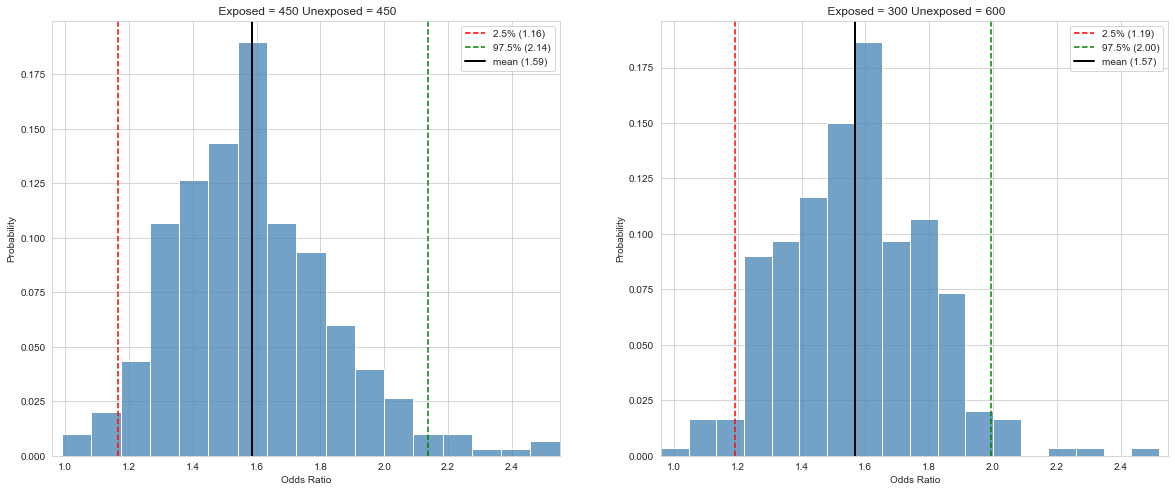

In [11]:
# Specify the parameters of the experiment here
exposed =[450, 300]
unexposed = [450, 600]
num_sims_per_trial = 300

experiment = simulate_OR_different_ss(num_sims_per_trial, exposed, unexposed)



,exposed_sample_size,unexposed_sample_size,Distribution_Odds_Ratios
0,450,450,"[1.36, 1.31, 1.53, 1.96, 1.46, 1.44, 1.68, 1.2..."
1,300,600,"[1.59, 1.29, 1.5, 1.61, 1.86, 1.42, 1.68, 1.57..."


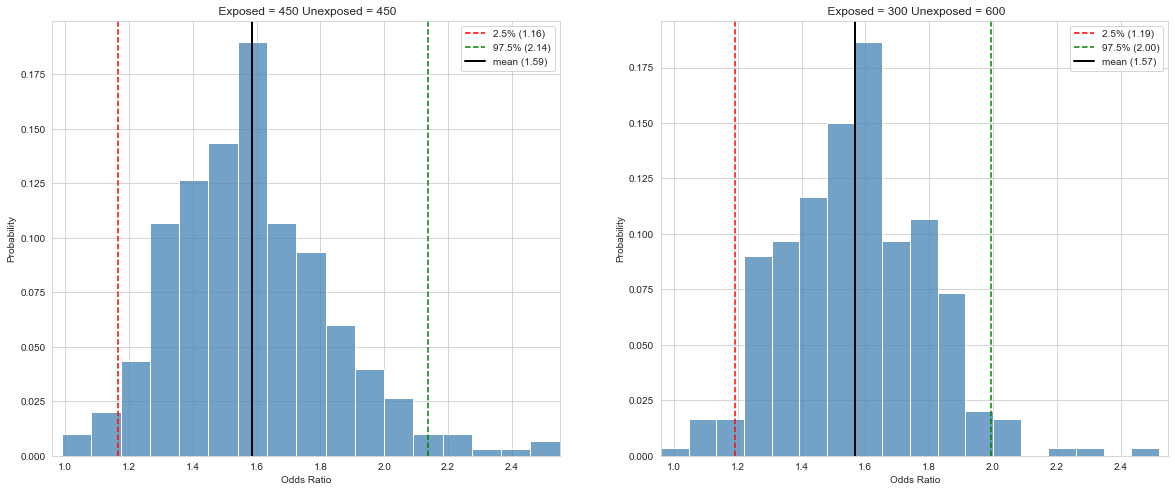

In [12]:

display(experiment)

visualizeExperiment(experiment, same_axis=True)